<a href="https://colab.research.google.com/github/hmblackwood/Portfolio/blob/main/The_Good_Dog_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

#🐕 The Good Dog Project 🦮

##Summary: I created a multi-class image classifier model with Tensorflow 2.0 to identify the breed of dog based on an image.

*** Convolutional Neural Network, deep learning, transfer learning. Image classification
Put a "skills demonstrated" section on website, readme for this project and in this intro section.

##1. Problem
Identify the breed of a dog based on an image.


##2. Data
The data is from the Stanford Dogs Dataset from the Dog Breed Indentification Completition on Kaggle.
https://www.kaggle.com/c/dog-breed-identification/data
Citation:
@misc{dog-breed-identification,
    author = {Will Cukierski},
    title = {Dog Breed Identification},
    year = {2017},
    howpublished = {\url{https://kaggle.com/competitions/dog-breed-identification}},
    note = {Kaggle}
}

## 3. Machine Learning model:
SSD-based ("Single Shot Detector") object detection model trained on Open Images V4 with ImageNet pre-trained MobileNet V2 as image feature extractor.
https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification/1?tfhub-redirect=true

##4. Evaluation
Model is evaluated on Multi Class Log Loss between the predicted probability and the obeserved target.
www.kaggle.com/competitions/dog-breed-identification/overview/evaluation


##5. Features
Information about the data:
- Unstructured data (images).
- 120 different classes, one for each breed of dog, into which images will be sorted.
- 10,000+ images of dogs in the training set, all of them labeled.
- 10,000+ images of dogs in the test set, all unlabeled. The model will be making predictions based on these.


In [53]:
# Import Tensorflow and Tensorflow Hub
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0
import tensorflow as tf
print("TF version:", tf.__version__)
import tensorflow_hub as hub
print("TF Hub Version:", hub.__version__)

TF version: 2.15.0
TF Hub Version: 0.16.1


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [55]:
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


# Initial Data Exploration

In [56]:
# View labels of my data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Good Dog Project/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [57]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


✅ Exploration of the label file looks good, with 120 unique breeds and 10,222 labeled examples on which to train my model.

In [58]:
# How many images of each of the 120 breeds?
labels_csv["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
brabancon_griffon,67
komondor,67


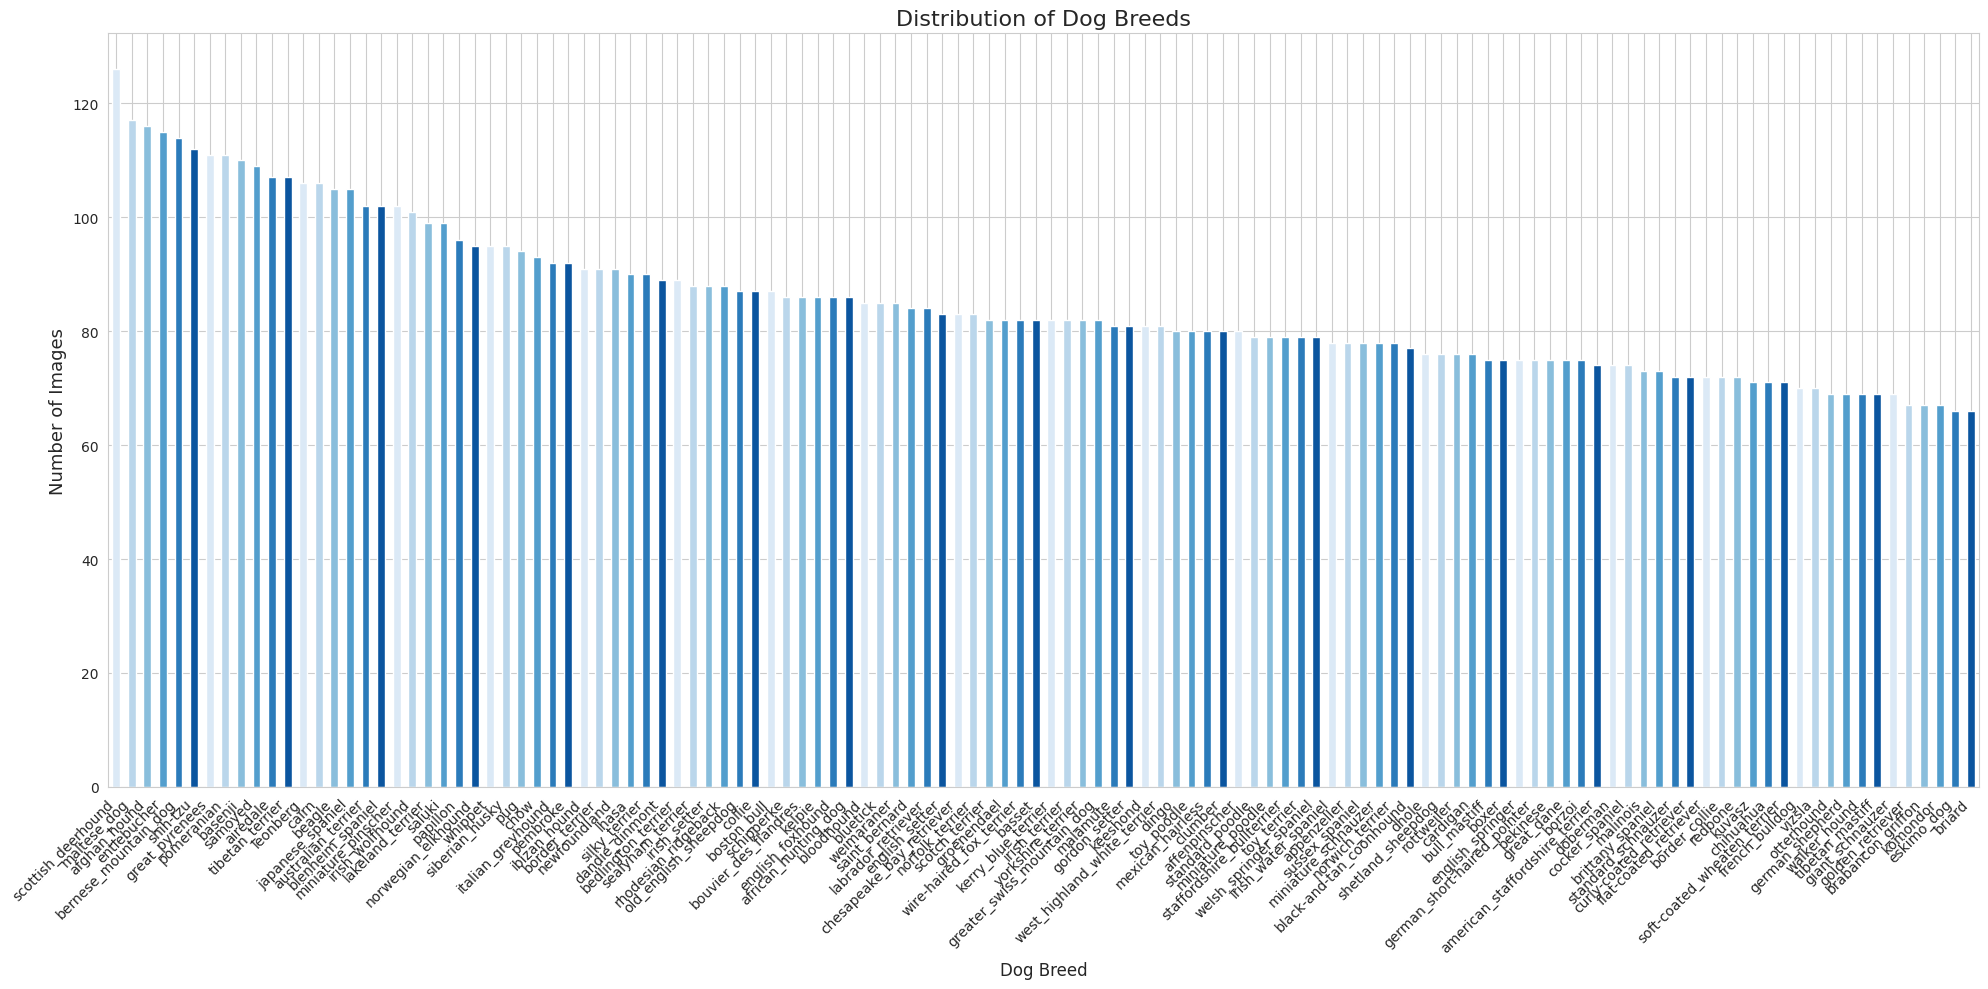

In [59]:
# I created a graph to display how many images of each breed I have.

breed_counts = labels_csv["breed"].value_counts()

# Set style and color pallette using Seaborn
sns.set_style("whitegrid")
sns.set_palette("Blues")

# Create bar chart
plt.figure(figsize=(20, 10))
breed_counts.plot(kind="bar", color=sns.color_palette())

# Label the chart for easier readability
plt.title("Distribution of Dog Breeds", fontsize=16)
plt.xlabel("Dog Breed", fontsize=12)
plt.ylabel("Number of Images", fontsize=13)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout() # Fix layout so X axis labels don't overlap.

plt.show;

In [60]:
# Calculate the median number of images per class
labels_csv["breed"].value_counts().median()

82.0

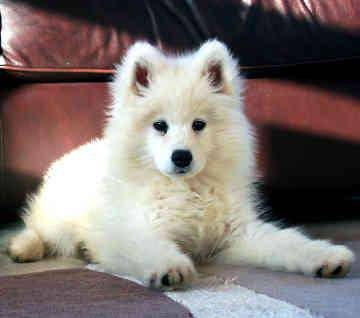

In [61]:
# View an image from the test set
from IPython.display import Image
Image("/content/drive/MyDrive/Good Dog Project/test/002c58d413a521ae8d1a5daeb35fc803.jpg")

Now, that's a good dog! 😃

# Preparing Images and Their Labels

In [62]:
# Check the image file names
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [63]:
# Create pathnames from the image IDs
filenames = [f"drive/MyDrive/Good Dog Project/train/{fname}.jpg" for fname in labels_csv["id"]]

In [64]:
# Check the first 10. These are currently strings, not the actual images.
filenames [:10]

['drive/MyDrive/Good Dog Project/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Good Dog Project/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Good Dog Project/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Good Dog Project/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Good Dog Project/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Good Dog Project/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Good Dog Project/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Good Dog Project/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Good Dog Project/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Good Dog Project/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [65]:
# Verify that the number of filenames matches the number of image files

import os
if len(os.listdir("drive/MyDrive/Good Dog Project/train/")) == len(filenames):
  print("Filenames match number of files.")
else:
  print("Filenames do not match number of files. Check the target directory.")

Filenames match number of files.


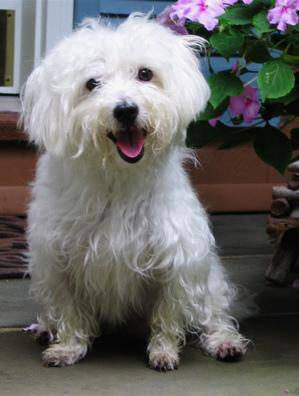

In [66]:
# Verify that data is in the correct format. Picked a random number for 4242.

Image(filenames[4242])

In [67]:
labels_csv["breed"][4242]

'maltese_dog'

Another good dog! 😃

## Prepare the Labels

In [68]:
# Make a numpy array of the labels
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [69]:
# Verify the length and that it matches with number of labels before. It does.
len(labels)

10222

In [70]:
# Verify that the number of labels equals the number of filenames.
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not match number of filenames. Check the data directories.")

Number of labels matches number of filenames.


In [71]:
# The labels are strings now. Need to convert them into numbers.
# Find out how many unique label values there are.
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [72]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

### Turn strings into boolean arrays
- Before I can convert the values into Tensors, I need to make them into numbers. I'll follow these steps:
1. Convert the strings into boolean arrays
2. Convert the boolean arrays into integers
3. Convert the integers into Tensors.

In [73]:
# Turn a single label into a boolean array
# I'll use a comparison operator to compare the first label to unique_breeds. It should give an array of true and false values. All values should be false, except one, which will be true.
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [74]:
# Turn all labels into boolean arrays
# I'll visualize the data and check that each array is all false values except for one true value, where the label matches.
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [75]:
# I'll turn boolean array into integers.
print(labels[0])  # original label
print(np.where(unique_breeds == labels[0]))  # index where label occurs
print(boolean_labels[0].argmax())  # index where label occurs in boolean array
print(boolean_labels[0].astype(int))  # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [76]:
# Visualize another example for label #2
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


✅ Everything looks good. Labels are now in boolean format.
Filenames (iamge paths) are still strings (not numeric), but I'll deal with that shortly.

# Creating our own Validation Set
The original data doesn't come with a validation set, only a test and train set. I will create a validation set myself so that I can do fine tuning on the model later.

In [77]:
# Set up X and y variables
X = filenames
y = boolean_labels

In [78]:
# Visualize to make sure.
len(filenames)

10222

In [79]:
len(boolean_labels)

10222

✅ I'll start off using ~1000 images and increase as needed

In [80]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [81]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split

# Split into training and validation sets so total size = NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [82]:
# Visualize the training data to make sure everything looks good.
X_train[:5], y_train[:2]

(['drive/MyDrive/Good Dog Project/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Good Dog Project/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Good Dog Project/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Good Dog Project/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Good Dog Project/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False

# Preprocessing Images (turn images into Tensors)


In [83]:
# Import an image and convert it into a NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

#The shape is height, width, color channel (rgb color)

(257, 350, 3)

In [84]:
# Look at the image as an array
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [85]:
# Turn the image into a Tensor. The only difference between the cell above and this one is that this is a Tensor.
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

## Creating the function

To preprocess the images into Tensors I'll create a function which will
1. Take an image filepath as input.
2. Use TensorFlow to read the file and save it to the variable, 'image'.
3. Turn our 'image' (a jpg) into Tensors.
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the image to be the shape of (224, 224).
6. Return modified image.

In [86]:
image_path = filenames

In [87]:
# Define the image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """

  # Read in an image file
  # Changed image_path to a single file path string.
  image = tf.io.read_file(image_path)
  # Turm the jpg into a numerical Tensor with three color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired shape of (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turn Data into Batches
1. Put data into TensorFlow tuples: (image, label)
2. Make batches of 32 images at a time

### Put data into TensorFlow tuples

In [88]:
# Create a function to return a tuple of tensors in the format (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the image and returns a tuple of: (image, label).
  """
  image = process_image(image_path)
  return image, label

In [89]:
# Test our function on image/label #42
(process_image(X[42]), y[42]) # makes it a tuple.


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [90]:
# Makes it into a tuple of tensors
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

### Put data into batches

In [91]:
# Define batch size. Using 32 as a common convention
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  If the data is training data, shuffles the data.
  If the data is validation data, does not shuffle the data.
  Alo can accept test data as input (no labels).
  """

  # If the data is a test dataset, it probably doesn't have labels.
  if test_data:
    print("Creating test data batches.")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))  # only filepaths (no labels)
    # Take the data (datset made of X, which is filenames in the form of Tensors) and map our process image function from above. Then turn it into a batch of BATCH_SIZE.
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches.")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping  image processor function is faster than shuffling images.
    data = data.shuffle(buffer_size=len(X))  # buffer size = how many variables we want shuffed. I want all of them.

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch


In [92]:
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data, but not if it's validation data.
  Can also accept test data as input (no labels).
  """
  if test_data:
    print("Creating test data batches.")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))  # only filepaths (no labels)
    # Map process_image to each individual image path
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("Creating validation data batches.")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Don't shuffle validation data
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches.")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffle training data
    data = data.shuffle(buffer_size=len(X))
    # Map process_image and create batches
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [93]:
# Create training and validatation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches.
Creating validation data batches.


In [94]:
# View the attributes of our data batches to verify that it looks fine.
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches
Data is now in batches. I will visualize them.

In [95]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Create a grid of subplots (5 rows, 5 columns) outside the loop
  fig, axes = plt.subplots(5, 5, figsize=(10, 10))
  # Flatten the axes array to easily iterate throughs subplots
  axes = axes.flatten()
  # Loop through 25 times
  for i in range(25):
    # Display an image
    axes[i].imshow(images[i])
    # Add the image label as the title. Argmax finds the index in the array containing "true" and thus identifies the breed of dog.
    axes[i].set_title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off for cleaner appearance
    axes[i].axis("off")

In [96]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

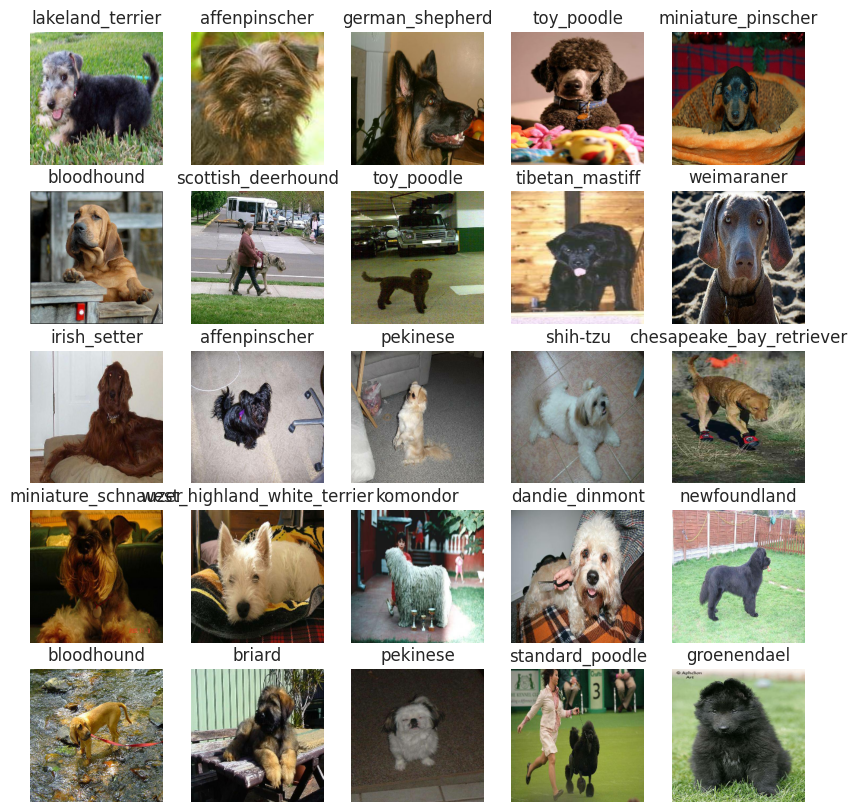

In [97]:
# Visualize the data in a training batch. "Unbatch" the data, turn it into an iterator, then return images and labels.
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

🐶 More good dogs! 😀

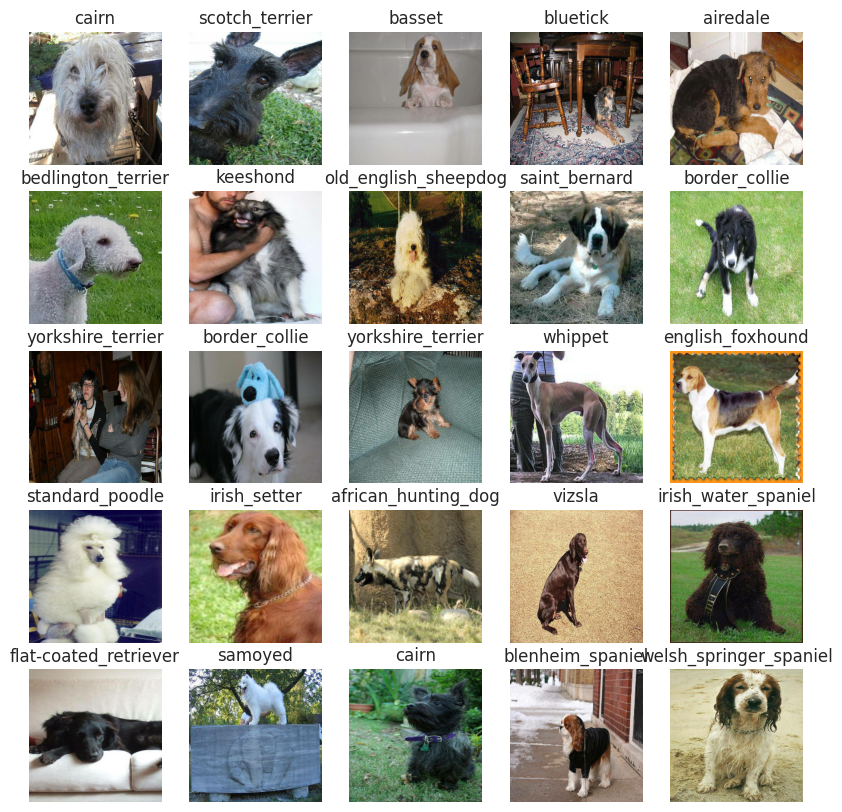

In [98]:
# Visualize the validation set also.
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

🐶 Such good dogs! 😀

# Building a Model
Before building a model, I need to define:
1. Input shape (images shape, in the form of Tensors) for the model.
2. Outputs shape (image labels, in teh form of Tensors) for the model.
3. The url of the model I will use from TensorFlow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [99]:
# Set up the input shape for the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]  # batch, height, width, color channels
# Set up output shape of the model
OUTPUT_SHAPE = len(unique_breeds)
# Set up the model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [100]:
# Check input shape to verify that everything looks good.
INPUT_SHAPE

[None, 224, 224, 3]

In [101]:
# Check otuput shape to verify that everything looks good.
OUTPUT_SHAPE

120

## Make a Function to Create the Model
The function will:
1. Take input shape, output shape, and the model I chose as parameters.
2. Defines the layers in a Keras model sequentially.
3. Compiles the model (says it should be evaluated and improved).
4. Builds the model (tells the model the input shape it will receive)
5. Returns the model.

✅ In step 2, setting up the layers, I chose to use a sequential model to pass the information through the model one time (not a recurrent neural network).

✅ For this problem (multi-class classification) I am using Softmax as the activation function and Categorical Crossentropy as the Loss function. If this had been a binary classification model, I would use the Sigmoid activation function and the Binary Crossentropy loss function. In either case, this would put the output into a useable format for me.

In [104]:
# 1. Function to build the Keras model.
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building the model with:", MODEL_URL)

  # 2. Set up the three model layers.
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),  # Layer 1: input layer
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax")  # Layer 2: output layer)
  ])
  # 3. Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # 4. Build the model
  model.build(INPUT_SHAPE)

  return model

In [105]:
model = create_model()
model.summary

Building the model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7edf99e82650>>